<h1>Instructions</h1>
<ol>
<li>Click the button "Not Trusted" on the menu bar of this notebook (at the top-right), and change the value to "Trusted". 
<li><b>Optional</b> - Install matplotlib. This step is necessary for certain QuadTree visualization functions. 
<li>Click Cell -> Run All. If you skip this step the visualization functions may not work. 
<li>Write Python code to answer the following questions. You may choose to answer either Q8 or Q9, but if you answer both, only the highest scoring answer will count towards your grade. 
<li>Please remember to save your notebook before submitting it on Compass2g. 
</ol>

<h2>Notes</h2>
<ul>
<li>Make sure that you are using Python 3.3 or above. We can make no guarantees that the framework code will work for older versions of Python. 
<li>Importing libraries beyond what has already been imported is <b>forbidden</b>. Any answer that contains an import statement will be given 0 points. 
</ul>



In [2]:
# code to render B-Tree as SVG

from IPython.display import SVG, display
import IPython.core.display as dis

from math import log, ceil, sqrt

# constants used for all SVG functions
xml_head = '<?xml version="1.0" encoding="UTF-8" ?>'
svg_head = '<svg xmlns="http://www.w3.org/2000/svg" version="1.1" width="%s" height="%s">'
defs = ['<defs>',
        '<marker id="arrowhead" viewBox="0 0 10 10" refX="10" refY="5" ' + \
        'markerUnits="strokeWidth" markerWidth="5" markerHeight="5" ' + \
        'orient="auto" >',
        '<path d="M 0 0 L 10 5 L 0 10 z" />',
        '</marker>',
        '</defs>']
arrow_style = { "marker-end" : "url(#arrowhead)" }
dashed_style = { "stroke-dasharray" : "5,5" }

# helper functions
def _style(kwargs):
    return " ".join(['%s="%s"' % (k, kwargs[k]) for k in kwargs])
def _line(x1 = 0, y1 = 0, x2 = 0, y2 = 0, kwargs = {}):
    return ('<path stroke="black" ' + _style(kwargs) + ' ' + \
            'd="M %f %f L %f %f" ' + '/>') % (x1, y1, x2, y2)
def _horiz(x1 = 0, y = 0, x2 = 0, kwargs = {}):
    return ('<path d="M %f %f H %f" ' + \
            'stroke="black" ' + _style(kwargs) + ' />') % (x1, y, x2)
def _vert(x = 0, y1 = 0, y2 = 0, kwargs = {}):
    return ('<path d="M %f %f V %f" ' + \
            'stroke="black" ' + _style(kwargs) + ' />') % (x, y1, y2)
def _rect_outline(x = 0, y = 0, w = 0, h = 0):
    return ('<rect x="%f" y="%f" width="%f" height="%f" ' + \
            'fill-opacity="0.0" stroke="black" />') % (x, y, w, h)
def _rect_fill(x = 0, y = 0, w = 0, h = 0, rgb=(125, 125, 125), opacity=1):
    return ('<rect x="{}" y="{}" width="{}" height="{}" ' + \
            'fill="rgb({}, {}, {})" ' + \
            'fill-opacity="{}" stroke="black" />').format(x, y, w, h, 
                                                          rgb[0], rgb[1], rgb[2],
                                                          opacity)
def _ellipse_outline(cx, cy, rx, ry):
    return ('<ellipse cx="%f" cy="%f" rx="%f" ry="%f" ' + \
            'fill-opacity="0.0" stroke="black" />') % (cx, cy, rx, ry)
def _text(x = 0, y = 0, font_size = 0, text = ""):
    return ('<text x="%f" y="%f" font-family="Times" ' + \
            'font-size="%f" fill="black">%s</text>') % \
           (x, y, font_size, text)
def _wrap_in_group(elems, x = 0, y = 0):
    return ['<g transform="translate(%f, %f)">' % (x, y)] + elems + ['</g>']

def tree_to_svg(tree, draw_leaf_sibling_ptrs = True):
    # constants
    n = tree.n
    box_width = 36.0
    box_height = 36.0
    ptr_width = box_width * n / (n + 1)
    child_spacing = 10.0
    block_child_space = 48.0
    font_size = 18.0

    def _block_to_svg(tree):
        """top level of a single subtree"""
        # draw box for keys
        elems = []
        elems.append(_rect_outline(w = n * box_width, h = box_height))

        # draw vertical separators for keys
        for i in range(1, n):
            elems.append(_vert(x = i * box_width, y2 = box_height))

        # draw box for pointers
        elems.append(_rect_outline(y = box_height, w = n * box_width,
                                   h = box_height))

        # draw vertical separators for pointers
        for i in range(1, n + 1):
            elems.append(_vert(x = i * ptr_width, y1 = box_height,
                               y2 = box_height * 2))

        # draw key values as text
        for i, k in enumerate(tree.keys):
            elems.append(_text(x = (i + 0.1) * box_width,
                               y = (box_height * 0.8),
                               font_size = font_size,
                               text = str(k)))

        # estimate size occupied by the leaf
        size = (n * box_width, 2 * box_height)
        return elems, size
    
    def _to_svg(tree):
        if tree.is_leaf():
            elems, size = _block_to_svg(tree)
            
            # draw boxes, text, pointers for objects
            for i, o in enumerate(tree.ptrs):
                elems.append(_rect_outline(x = i * box_width, y = size[1] + block_child_space,
                                           w = ptr_width, h = ptr_width))
                elems.append(_text(x = (i + 0.1) * box_width, y = size[1] + block_child_space + ptr_width * 0.8,
                                   font_size = font_size, text = str(o)))
                elems.append(_line(x1 = (i + 0.5) * ptr_width, y1 = size[1],
                                   x2 = i * box_width + 0.5 * ptr_width, y2 = size[1] + block_child_space,
                                   kwargs = arrow_style))
                
            return elems, size
            
        else:
            # recursively convert the child subtrees into svg first
            child_elems = []
            child_sizes = []
            for c in tree.ptrs:
                elems, size = _to_svg(c)
                child_elems.append(elems)
                child_sizes.append(size)

            # find the total width / height occupied by child subtrees
            total_width = sum([w for w, _ in child_sizes]) + \
                          child_spacing * (len(child_sizes) - 1)
            child_height = max([h for _, h in child_sizes])

            # put keys of this subtree in top-center
            block_elems, block_size = _block_to_svg(tree)
            dx = (total_width - block_size[0]) // 2
            block_elems = _wrap_in_group(block_elems, dx)
            total_height = child_height + block_size[1] + block_child_space

            # put children at bottom, evenly spaced out
            cur_x = 0
            cur_i = 0
            last_x_end = None
            for c_elems, c_size in zip(child_elems, child_sizes):
                c_elems = _wrap_in_group(c_elems, x = cur_x,
                                         y = block_size[1] + block_child_space)
                block_elems += c_elems

                # draw arrows from block to children
                block_elems.append(_line(x1 = dx + (cur_i + 0.5) * ptr_width,
                                         y1 = 1.5 * box_height,
                                         x2 = cur_x + 0.5 * c_size[0],
                                         y2 = block_size[1] + block_child_space,
                                         kwargs = arrow_style))

                # draw arrow from ptr in last leaf to this leaf
                # assumes that the tree is balanced
                if draw_leaf_sibling_ptrs:
                    if last_x_end is not None:
                        y = block_size[1] + block_child_space + c_size[1] - \
                            box_height / 2
                        block_elems.append(_line(x1 = last_x_end,
                                                 y1 = y,
                                                 x2 = cur_x,
                                                 y2 = y,
                                                 kwargs = arrow_style))
                    last_x_end = cur_x + c_size[0] + child_spacing - box_width / 2

                cur_x += c_size[0] + child_spacing
                cur_i += 1
            
            return block_elems, (total_width, total_height)

    elems, size = _to_svg(tree)
    elems = _wrap_in_group(elems, x = 2, y = 2)
    size = (size[0] + 5, size[1] + 5 + block_child_space + ptr_width)
    elems = [xml_head] + [svg_head % size] + defs + elems + ['</svg>']
    return '\n'.join(elems)

# quad tree visualization

def quad_tree_to_svg(tree, max_num_digits=4):
    # constants
    n = tree.n
    m = tree.node_capacity
    
    box_width = max_num_digits * 12 + 6
    box_height = 36.0
    ptr_width = box_width * n / (n + 1)
    child_spacing = 10.0
    block_child_space = 48.0
    font_size = 18.0

    
    def _centroid_to_svg(point):
        block_size = [n * box_width, box_height]
        block_elems = []
        block_elems.append(_rect_fill(w=len(point)*box_width, h=box_height,
                                     rgb=(125, 125, 125), opacity=0.5))
        for i in range(1, len(point)):
            block_elems.append(_vert(x=i*box_width, y2=box_height))
                           
#         block_elems = [_ellipse_outline(cx = block_size[0] // 2, cy = block_size[1] // 2, 
#                                         rx = box_width, ry = box_height // 2) ]
        
        text_vals = ["{:.4g}".format(v) for v in point]
        for i, v in enumerate(text_vals):
            block_elems.append(_text(x=(i + 0.1)*box_width, y=0.75*box_height, 
                                     font_size=font_size,
                                     text=v))

        return block_elems, block_size
    
    def _block_to_svg(tree):
        """top level of a single subtree"""

        n = tree.n
        m = tree.node_capacity    

        elems = []

        if tree.empty():
            size = (tree.n * box_width, box_height)
            return elems, size

        # Draw boxes
        for i in range(m):
            elems.append(_rect_outline(y=i*box_height, w=n*box_width, h=box_height))
        # Draw vertical separators            
        for j in range(m):
            for i in range(1, n):
                elems.append(_vert(x=i*box_width, y1=j*box_height, y2=(j + 1)*box_height))    
        # Draw values as text
        for i, pt in enumerate(tree.points):
            for j, val in enumerate(pt):
                elems.append(_text(x=(j + 0.1) * box_width, 
                                   y=(box_height * (i + 0.75)),
                                   font_size=font_size,
                                   text=str(val)))

        # estimate size occupied by the leaf
        size = (n * box_width, m * box_height)
        return elems, size           
    
    
    def _to_svg(tree):
        if tree.is_leaf():
            return _block_to_svg(tree)
        else:
            # recursively convert the child subtrees into svg first
            child_elems = []
            child_sizes = []
            for c in tree.children:
                elems, size = _to_svg(c)
                child_elems.append(elems)
                child_sizes.append(size)

            # find the total width / height occupied by child subtrees
            total_width = sum([w for w, _ in child_sizes]) + \
                          child_spacing * (len(child_sizes) - 1)
            child_height = max([h for _, h in child_sizes])

            # put centroid of this subtree in top-center
            center = tree.region.center
            block_elems, block_size = _centroid_to_svg(center)            
            dx = (total_width - block_size[0]) // 2
            block_elems = _wrap_in_group(block_elems, dx)
            total_height = child_height + block_size[1] + block_child_space
            cx = dx + box_width  # Center of parent block
            
            # put children at bottom, evenly spaced out
            cur_x = 0
            cur_i = 0
            last_x_end = None
            
            n_elems = len(child_elems)
            for i, (c_elems, c_size, region) in enumerate(zip(child_elems, 
                                                              child_sizes, 
                                                              tree.regions)):            
                c_elems = _wrap_in_group(c_elems, x = cur_x,
                                         y = block_size[1] + block_child_space)
                block_elems += c_elems

                # draw arrows from block to children
                x2 = cur_x + 0.5 * c_size[0]
                y2 = block_size[1] + block_child_space
                block_elems.append(_line(x1 = cx,
                                         y1 = box_height,
                                         x2 = x2,
                                         y2 = y2,
                                         kwargs = arrow_style))
                
                x = x2 - box_width if i < n_elems / 2 else x2                        
                block_elems.append(_text(x = x, 
                                         y = y2 - 0.1 * box_height, 
                                         font_size=font_size, text=region))

                cur_x += c_size[0] + child_spacing
                cur_i += 1
            
            return block_elems, (total_width, total_height)

    elems, size = _to_svg(tree)
    elems = [xml_head] + [svg_head % size] + defs + elems + ['</svg>']
    return '\n'.join(elems)

def plot_tree_as_spatial_map(tree, figsize=(10, 10), max_line_width=3, marker_size=40, pady=2, padx=2):
    try:
        import matplotlib.pyplot as plt
    except BaseException:
        print("Matplotlib is not installed")
        return
    
    def _plot_regions_for_tree(ax, tree, level):
        if tree.is_leaf() or tree.empty():
            return
        
        region = tree.region
        center = region.center
        
        linewidth = max(1, 1.0 / sqrt(level) * max_line_width)        
        # Plot horizontal line        
        ax.plot([region.p1.x, region.p2.x], [center.y, center.y], 
                 'k--', linewidth=linewidth)
        # Plot vertical line
        ax.plot([center.x, center.x], [region.p1.y, region.p2.y], 
                 'k--', linewidth=linewidth)
        for child in tree.children:
            if not (child.is_leaf() or child.empty()):
                _plot_regions_for_tree(ax, child, level + 1)
        
    region = tree.region
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim([region.p1.x - padx, region.p2.x + padx])
    ax.set_ylim([region.p1.y - pady, region.p2.y + pady])
    
    pts = tree.all_points_in_tree()
    if pts:       
        X = [p.x for p in pts]
        Y = [p.y for p in pts]    
        min_x, max_x = min(X), max(X)
        min_y, max_y = min(Y), max(Y)

        _plot_regions_for_tree(ax, tree, 1)
        zorder = tree.depth() + 1        
        ax.scatter(X, Y, s=marker_size, color="blue", zorder=zorder)
    
    return ax
    

def plot_points_in_region(ax, tree, region, marker_size=40, marker_color="red", rect_color="red"):
    try:
        import matplotlib.patches as patches
    except BaseException:
        print("Matplotlib is not installed")
        return
    
    pts = tree.find_points_in_region(region)
    X = [p.x for p in pts]
    Y = [p.y for p in pts]
    ax.scatter(X, Y, color=marker_color, s=marker_size, zorder=tree.depth() + 2)
    
    ax.add_patch(
    patches.Rectangle(
        (region.p1.x, region.p1.y),
        region.width,
        region.height,
        color=rect_color,
        linestyle="--",
        fill=False      # remove background
    ))
    
    return ax

# hash table visualization code

def unique(lst):
    """Get unique items in list, while preserving order of items"""
    ret = []
    for x in lst:
        if x not in ret:
            ret.append(x)
    return ret

def hash_table_to_svg(h):
    if type(h) not in [ChainedHashTable, ExtensibleHashTable, LinearHashTable]:
        print("Visualization not supported for this type of table")
        return
    
    y_margin_top = 50
    hash_code_width = 50
    font_size = 16
    block_height = 20
    block_separator = 25
    
    # convert integer hash code into string of binary digits, with consistent length
    code_size = int(ceil(log(h.b, 2))) if type(h) == ChainedHashTable else h.i
    def _get_code(x, size = code_size):
        t = str(bin(int(x)))[2:]
        t = "0" * (size - len(t)) + t
        return t
    
    def _bucket_to_svg(bucket):
        # draw bucket as svg, with top-left of bucket at (0, 0)
        height = block_height * h.bucket_size
        elems = []
        elems.append(_rect_outline(x = 0, y = 0, w = 100, h = height))
        for i in range(h.bucket_size):
            if i < len(bucket):
                item = bucket[i]
                c = _get_code(h.h(item[h.key_attr]), h.k)
                if type(h) == ExtensibleHashTable:
                    c = c[: bucket.nub] + "(" + c[bucket.nub :] + ")"
                elif type(h) == LinearHashTable:
                    c = "(" + c[: -h.i] + ")" + c[-h.i :]
                t = c + " " + str(item)
                elems.append(_text(x = 10, 
                                   y = block_height * i + 15, 
                                   font_size = font_size, text = t))
            if i != 0:
                elems.append(_line(x1 = 0, y1 = block_height * i, 
                                   x2 = 100, y2 = block_height * i,
                                   kwargs = dashed_style))
        
        # draw nub
        elems.append(_rect_outline(x = 100, y = 0, w = block_height, h = block_height))
        if bucket.nub is not None:
            elems.append(_text(x = 100 + 5, 
                               y = 15, font_size = font_size, text = str(bucket.nub)))
        size = (100 + block_height, height)
        return elems, size
    
    # display variables at top
    elems = []
    for i, (var_name, var_value) in enumerate(sorted(h.get_vars().items())):
        elems.append(_rect_outline(x = (i + 1) * 50, y = 1, w = 50, h = 20))
        elems.append(_text(x = (i + 1) * 50 + 5, y = 15, font_size = font_size, 
                           text = var_name + " = " + str(var_value)))
    
    index_elems = []
    cur_y = y_margin_top
    
    # draw hash table index for hash tables with a level of indirection
    if h.indirection:
        for x in range(len(h.table)):
            index_elems.append(_rect_outline(x = hash_code_width, y = cur_y, 
                                             w = 50, h = block_height))
            index_elems.append(_text(x = 0, y = cur_y + 15, 
                                     font_size = font_size, text = _get_code(x)))
            cur_y += block_height
            
    # draw hash table buckets
    cur_y2 = y_margin_top
    max_x = 300
    buckets = unique(h.table)
    buckety = []
    for x, bucket in enumerate(buckets):
        cur_x = hash_code_width + 50 + 50
        bucket_elems, (_, height) = _bucket_to_svg(bucket)
        if not h.indirection:
            bucket_elems.append(_text(x = -50, y = 15, 
                                      font_size = font_size, text = _get_code(x)))
        elems += _wrap_in_group(bucket_elems, x = cur_x, y = cur_y2)
        
        # draw all overflow buckets to the right of this bucket
        while bucket.overflow:
            bucket = bucket.overflow
            cur_x = cur_x + 100 + block_height + 50
            elems.append(_line(x1 = cur_x - 50, y1 = cur_y2 + block_height / 2, 
                               x2 = cur_x, y2 = cur_y2 + block_height / 2,
                               kwargs = arrow_style))
            bucket_elems, (_, height2) = _bucket_to_svg(bucket)
            elems += _wrap_in_group(bucket_elems, x = cur_x, y = cur_y2)
            max_x = max(max_x, cur_x + 100 + block_height)
            height = max(height, height2)
        
        buckety.append(cur_y2)
        cur_y2 += height
        if h.indirection:
            cur_y2 += block_separator
    
    # draw pointers, if there is a level of indirection in the hash table
    if h.indirection:
        dy = (cur_y2 - cur_y - block_separator) / 2
        elems += _wrap_in_group(index_elems, y = dy)
    
        cur_y = y_margin_top
        for x, bucket in enumerate(h.table):
            height = block_height * h.bucket_size
            i = buckets.index(bucket)
            elems.append(_line(x1 = hash_code_width + 50 / 2, y1 = dy + cur_y + 10,
                               x2 = hash_code_width + 50 + 50, y2 = buckety[i] + height // 2,
                               kwargs = arrow_style))
            cur_y += block_height
    
    size = (max_x + 5, max(cur_y, cur_y2) + 5)
    elems = [xml_head] + [svg_head % size] + defs + elems + ['</svg>']
    return '\n'.join(elems)

# hide this code cell
html = """
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input:eq(0)').hide();
    } else {
      $('div.input:eq(0)').show();
    }
    code_shown = !code_shown;
  }
  
  code_shown=true;
  code_toggle();
</script>
"""
dis.display_html(html, raw=True)


# Part 1 - Single-level index

## Question 1 [10 pts]:

Suppose that we want to build an index for a relation $R$ on a key $K$. Also, suppose that the number of records in R is $n$, the size of a record is $s$ bytes, the size of a key-pointer pair is $k$ bytes, and the size of a data block is $b$ bytes. Assuming that the index is dense and unclustered, write a Python function to find the minimum possible number of blocks needed to store the index, given the above variables. 

In [3]:
def floor(a,b):
    if a%b == 0:
        return(a/b)
    else:
        return(a//b)
    
def compute_size_of_dense_unclustered_index(n, s, k, b):
#     num1=floor(b,k)
#     num=ceil(n,num1)
    num1=n*k
    num2=num1/b
    return ceil(num2)

## Question 2 [10 pts]:

Now suppose that the index is sparse and clustered. Write a Python function to find the minimum possible number of blocks to store this index, given the same variables as before. 

In [4]:
def compute_size_of_sparse_clustered_index(n, s, k, b):
    a=n*s
    num=a/b
    num=ceil(num)
    num2=floor(b,k)
    num3=num/num2
    num3=ceil(num3)
    return num3


# Part 2 - B-Tree

The code below defines a `BTree` class, which recursively defines the B-Tree data structure. This means that the root, interior nodes, and leaf nodes of a B-Tree are all instances of the `BTree` class. Each node contains either the variable $n$, which matches the textbook definition, or the variable $d$, which corresponds to the degree as taught in the lecture slides. For all nodes, the `keys` property is a variable-length list of keys that partition the children of the node. For interior nodes, the `ptrs` property is a list of `BTree` instances that define the child subtrees of the node. For leaf nodes, the `ptrs` property is a list of objects indexed by the B-Tree, such that `leaf.keys[i]` contains the key of `leaf.ptrs[i]`. It is recommended that you understand the example B-Tree defined in Question 6 before attempting Questions 3-5. 

In [5]:

class BTree:
    def __init__(self, keys = [], ptrs = [], n = None, d = None):
        """Parameters: keys - a variable-length list that stores the keys for either an interior or leaf node.
                       ptrs - a variable-length list that stores pointers to lower-level nodes in the case of interior nodes, 
                              and pointers to data records in the case of leaf nodes.
                       n - maximum number of keys of any subtree in this tree.
                       d - degree of this tree. 
        """
        self.keys = keys
        self.ptrs = ptrs
        if n != None or d != None:
            self.n = n
            self.d = d
            self._propogate(n, d)

    def _propogate(self, n, d):
        # propogate n / d to all subtrees; so that when defining a B-Tree
        # the value of n / d needs to only be passed to the root node
        if not self.is_leaf():
            for c in self.ptrs:
                c.n = n
                c.d = d
                c._propogate(n, d)

    # properties

    def is_leaf(self):
        """Return true iff this part of the BTree is a leaf. 
           Assumes that the BTree is balanced and that pointers have the right types.
        """
        return not any([isinstance(c, BTree) for c in self.ptrs])

    def depth(self):
        """Return the depth of this subtree, where depth = distance from this node to a leaf.
           Assumes that the BTree is balanced.
        """
        if self.is_leaf():
            return 0
        else:
            return self.ptrs[0].depth() + 1

    def leaves(self):
        """Gather all leaves that are below this subtree.
           Assumes that the BTree is balanced.
        """
        if self.is_leaf():
            return self.keys
        else:
            leaves = []
            for c in self.ptrs:
                leaves += c.leaves()
            return leaves

    # functions
    def lookup(self, key):
        return self.lookup_helper(key)
    
    def lookup_helper(self,key):
#         print("we are at")
#         print(self.keys)
        if self.is_leaf():
            for k in self.keys:
                if k==key:
                    #print("found key: "+str(key))
                    return str(key)
            return None
        
        else:
            for index, k in enumerate(self.keys):
                if key<k:
                    btree=self.ptrs[index]
                    return btree.lookup(key)
                elif key==k:
                    btree=self.ptrs[index+1]
                    return btree.lookup(key)
            btree=self.ptrs[len(self.ptrs)-1]
            return btree.lookup(key)       

    # check for B-Tree conditions
    def _check_block_usage_between_half_and_full(self, is_root = True):
        if self.is_leaf() and is_root:
            assert len(self.ptrs)>=2, "root does not have enough ptrs" 
        if self.is_leaf():
            num=self.n+1
            assert len(self.keys)<=self.n and len(self.keys)>=floor(num,2), "at most n pointers used"
            
        elif is_root:
            assert len(self.ptrs)>=2, "root does not have enough ptrs"
            for ptr in self.ptrs:
                ptr._check_block_usage_between_half_and_full(is_root=False)
                
        else:
            num=float((self.n+1))/2
            assert len(self.ptrs)<=(self.n+1) and len(self.ptrs)>=ceil(num), "at most n+1 pointers used at least n/2 pointers used"
            for ptr in self.ptrs:
                ptr._check_block_usage_between_half_and_full(is_root=False)
            

    def _check_is_balanced(self, is_root = True):  
        assert self.checkBalance(is_root=True), "tree not balanced"
                
    def checkBalance(self,is_root=True):
#         print(" on keys: ")
#         print(self.keys)
        if self.depth()==0:
            return True
        else:
            d=self.ptrs[0].depth()
#             print("1st child's depth is "+str(d))
#             print("depth of each child should be:")
            count=0
            for ptr in self.ptrs:
#                 print("child "+str(count)+' is '+str(ptr.depth()))
                retVal=ptr.checkBalance(is_root=False) and (ptr.depth()==d)
        return retVal
        

    def _check_leaves_are_sorted(self):
        leaves = self.leaves()
        for i, j in zip(leaves[: -1], leaves[1 :]):
            assert i <= j, \
                   "Leaves are not sorted in ascending order from left to right"

    def check(self, is_root = True):
        assert 1 <= self.n and bool(is_root) in [True, False], \
               "Unexpected parameter type"
        self._check_block_usage_between_half_and_full(is_root)
        self._check_is_balanced(is_root)
        self._check_leaves_are_sorted()
        
    def show(self):
        display(SVG(data = tree_to_svg(self)))

## Question 3 [5 pts]:

Every B-Tree has the following constraints on the number of pointers that each node in the tree uses:
 * At a leaf node, at most $n$ and at least $\lfloor (n + 1)/2 \rfloor$ pointers are used, and point to data records. 
 * At an interior node, at most $n + 1$ pointers can be used to point to lower level nodes. At least $\lceil (n + 1)/2 \rceil$ of these pointers are used. 
 * The root node must use at least two pointers, regardless of how large $n$ is. 
 
Modify the function `_check_block_usage_between_half_and_full` in the B-Tree class above to throw an exception if the B-Tree object does not satisfy all of these properties. You can use either the variable `n` or the degree `d` in your code. 

**Note** - You can use the following functions to throw an exception. 
 * `assert [condition], [string_message]`
 * `raise BaseException([string_message])`

**Note** - The following Python code fragments may come in handy: `self.n`, `self.d`, `self.is_leaf()`, `len(self.ptrs)`, `int(x)`

## Question 4 [5 pts]:

Modify the function `_check_is_balanced` in the B-Tree class above to check whether the B-Tree object is balanced, i.e. if every path from the root to a leaf is the same length. The function should throw an exception if this property is not satisfied. 

**Note** - the following Python code fragments may come in handy: `self.is_leaf()`, `for child in self.ptrs`

## Question 5 [10 pts]:

Modify the function `lookup` in the B-Tree class to find the data record associated with a particular key. 

**Note** - You can assume that there are no duplicate keys in the B-Tree. 

**Note** - The following code fragments may be useful: `self.is_leaf()`, `self.keys[i]`

## Question 6 [20 pts total]: (questions independent of each other)

Construct a B-Tree object to show what the B-Tree below will look like after each of the following operations are performed. You can assume that the degree of the tree is 1 (in other words, n = 2). You can use the BTree.show() function to visualize the B-Tree object. You can also use the BTree.check() function to call the functions you have written in Q3-4. 

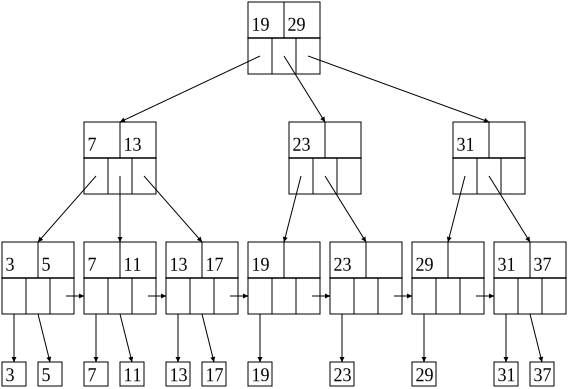

In [6]:
btree = BTree([19, 29],
              [BTree([7, 13],
                     [BTree([3, 5], ["3", "5"]),
                      BTree([7, 11], ["7", "11"]),
                      BTree([13, 17], ["13", "17"])
                     ]),
               BTree([23],
                     [BTree([19], ["19"]),
                      BTree([23], ["23"])
                     ]),
               BTree([31],
                     [BTree([29], ["29"]),
                      BTree([31, 37], ["31", "37"])
                     ])
              ],
              n = 2, d = 1)
btree.show()


### (a)
Insert 33 into the original tree. 

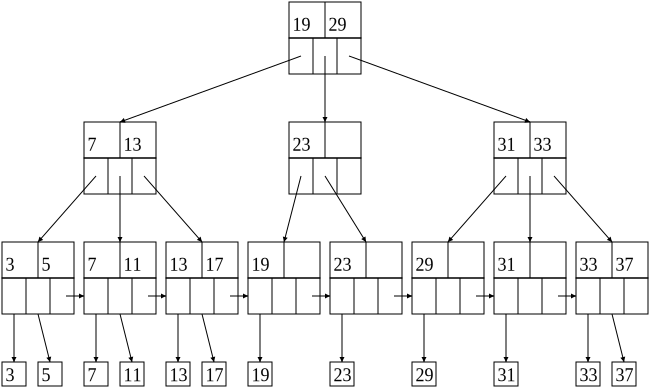

In [17]:
btree_6a = BTree([19, 29],
              [BTree([7, 13],
                     [BTree([3, 5], ["3", "5"]),
                      BTree([7, 11], ["7", "11"]),
                      BTree([13, 17], ["13", "17"])
                     ]),
               BTree([23],
                     [BTree([19], ["19"]),
                      BTree([23], ["23"])
                     ]),
               BTree([31,33],
                     [BTree([29], ["29"]),
                      BTree([31], ["31"]),
                      BTree([33, 37], ["33", "37"])
                     ])
              ],
              n = 2, d = 1)
btree_6a.show()

### (b) 
Insert 15 into the original tree.

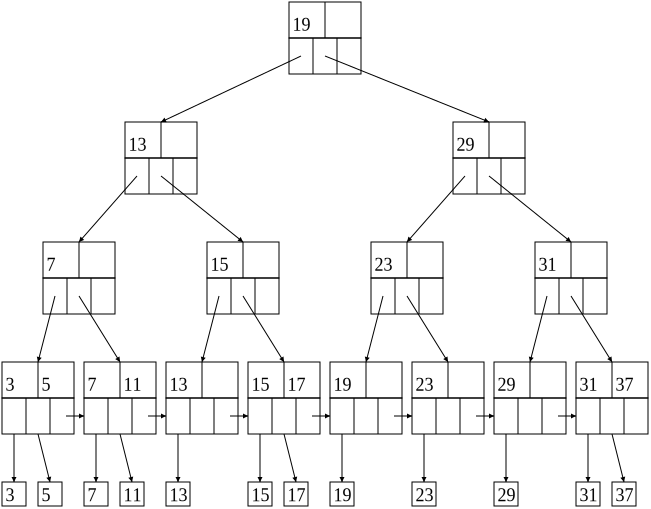

In [19]:
btree_6b = BTree([19],
              [BTree([13],
                     [
                      BTree([7], [
                              BTree([3,5], ["3", "5"]),
                              BTree([7,11], ["7", "11"])
                             ]),
                      BTree([15], [
                                  BTree([13], ["13"]),
                                  BTree([15,17], ["15", "17"])
                                 ])
                     ]),
               BTree([29],
                     [
                      BTree([23], [
                              BTree([19], ["19"]),
                              BTree([23], ["23"])
                             ]),
                      BTree([31], [
                                  BTree([29], ["29"]),
                                  BTree([31,37], ["31", "37"])
                                 ])
                     ])
              ],
              n = 2, d = 1)
btree_6b.show()

### (c) 
Delete 29 from the original tree. 

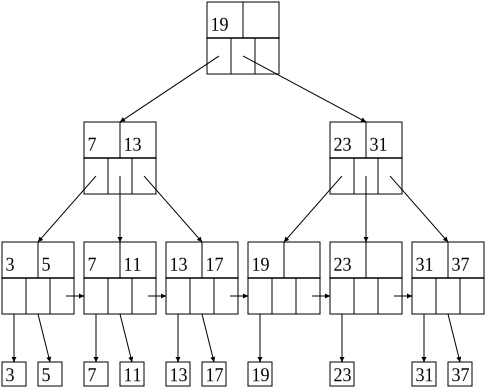

In [18]:
btree_6c = BTree([19],
              [BTree([7, 13],
                     [BTree([3, 5], ["3", "5"]),
                      BTree([7, 11], ["7", "11"]),
                      BTree([13, 17], ["13", "17"])
                     ]),
               BTree([23,31],
                     [BTree([19], ["19"]),
                      BTree([23], ["23"]),
                      BTree([31,37], ["31","37"])
                     ])
              ],
              n = 2, d = 1)
btree_6c.show()

### (d) 
Delete 23 from the original tree. 

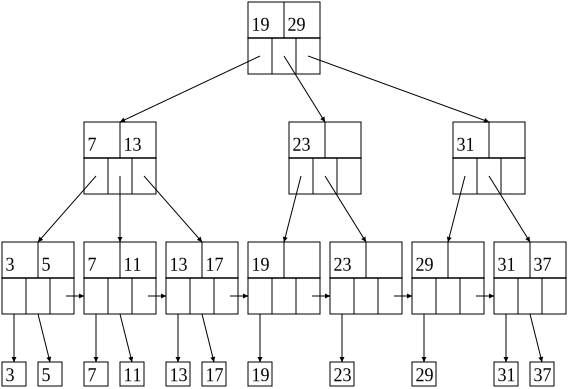

In [10]:
btree_6d = BTree([13, 29],
              [BTree([7],
                     [BTree([3, 5], ["3", "5"]),
                      BTree([7, 11], ["7", "11"])
                     ]),
               BTree([19],
                     [BTree([13,17], ["13","17"]),
                      BTree([19], ["19"])
                     ]),
               BTree([31],
                     [BTree([29], ["29"]),
                      BTree([31, 37], ["31", "37"])
                     ])
              ],
              n = 2, d = 1)
btree.show()

# Part 3 - Hash Table

The code below defines classes for chained hash tables (i.e., fixed-size hash tables with overflow buckets), extensible hash tables and linear hash tables. Every hash table has the `table` property, which represents a bucket array. The `table` property is expected to be a list of `Bucket` objects. In the case of extensible hash tables, there may be two or more entries that point to the same `Bucket` object, to reflect the fact that there is a level of indirection. 

Every hash table also has the property `k`, the number of bits that the hash function returns, the property `bucket_size`, the maximum number of records that fit in a single bucket, and the property `key_attr`, which is an integer such that `item[self.key_attr]` returns the key of a record. Hash tables have the class function `h`, which returns `k` bits of the hash value of an object. 

The `Bucket` object behaves identically to a Python list, but it contains the additional properties `nub` and `overflow`. A `Bucket` can store an arbitrary amount of items, but it is expected that the size of the bucket be $\le$ `bucket_size`. In the case of extensible hash tables, the `nub` can be an integer that stores additional information about a bucket. In the case of chained and linear hash tables, `overflow` can be a pointer to another `Bucket` object, or `None` if there is no need for an overflow bucket. 

In [11]:
class Bucket(list):
    def __init__(self, iterable = None, nub = None, overflow = None):
        if iterable is not None:
            super(Bucket, self).__init__(iterable)
        self.nub = nub
        self.overflow = overflow
        
    def size(self):
        return len(self)
    
    @property
    def id(self):
        return id(self)
    
    def __eq__(self, other):
        return self.id == other.id
    
    def __neq__(self, other):
        return self.id != other.id
    
    def __add__(self, other):
        return Bucket(super(Bucket, self).__add__(other), 
                      nub = self.nub, overflow = self.overflow)
    
    def __mul__(self, other):
        return Bucket(super(Bucket, self).__mul__(other), 
                      nub = self.nub, overflow = self.overflow)
    
    def __reversed__(self):
        return Bucket(super(Bucket, self).__reversed__(),
                     nub = self.nub, overflow = self.overflow)
    
    def __getitem__(self, arg):
        if isinstance(arg, slice):
            return Bucket(super(Bucket, self).__getitem__(arg),
                         nub = self.nub, overflow = self.overflow)
        else:
            return super(Bucket, self).__getitem__(arg)

class HashTable:
    def __init__(self, k, bucket_size, key_attr):
        # initialize an empty hash table
        self.table = []
        self.k = k
        self.bucket_size = bucket_size
        self.key_attr = key_attr
        
        assert k <= 63, "k is larger than max value of 63: " + str(k)
        
    def h(self, x):
        return int(str(bin(hash(x)))[2 :][-self.k :], base = 2)
    
    def insert(self, item):
        raise RuntimeError("Insert operation not implemented")
        
    def delete(self, key):
        raise RuntimeError("Delete operation not implemented")
        
    def show(self):
        display(SVG(data = hash_table_to_svg(self)))
        
def _coalesce_bucket_with_overflow(bucket, bucket_size):
    # if possible, move as many items from start of overflow bucket to this bucket
    if len(bucket) < bucket_size and bucket.overflow:
        n_to_move = bucket_size - len(bucket)
        to_move = bucket.overflow[: n_to_move]
        bucket.extend(to_move)
        del bucket.overflow[: n_to_move]

        # consolidate buckets if overflow bucket is empty
        if len(bucket.overflow) == 0:
            bucket.overflow = bucket.overflow.overflow
        
def insert_into_bucket(bucket, item, bucket_size):
    """add a single item into the bucket or one of its overflow buckets"""
    while not len(bucket) < bucket_size:
        if not bucket.overflow:
            bucket.overflow = Bucket()
        bucket = bucket.overflow
    bucket.append(item)

def get_all_from_bucket(bucket):
    """get all items from this bucket and its overflow buckets"""
    items = []
    while bucket:
        items += list(bucket)
        bucket = bucket.overflow
    return items

def delete_from_bucket(bucket, item, bucket_size):
    """delete a single item from the bucket"""
    while bucket:
        if item in bucket:
            bucket.remove(item)
            _coalesce_bucket_with_overflow(bucket, bucket_size)
            return
        bucket = bucket.overflow
        
class ChainedHashTable(HashTable):
    indirection = False
    
    def __init__(self, b, k = 32, bucket_size = 2, key_attr = 0):
        super(ChainedHashTable, self).__init__(k, bucket_size, key_attr)
        self.b = b
        self.table = [Bucket() for _ in range(self.b)]
        
    def get_vars(self):
        return { "b" : self.b }
        
    def insert(self, item):
        m = self.h(item[self.key_attr])
        bucket = self.table[m]
        insert_into_bucket(bucket, item, self.bucket_size)
        
    def delete(self, key):
        m = self.h(key)
        bucket = self.table[m]
        while bucket:
            for item in bucket:
                if item[self.key_attr] == key:
                    bucket.remove(item)
            
            # if possible, move as many items from start of overflow bucket to this bucket
            _coalesce_bucket_with_overflow(bucket, self.bucket_size)
            bucket = bucket.overflow
        
def get_jth_bit_from_the_left(x, j, k):
    """Get the jth highest bit, where j is a 1-indexed number and k is the total number of bits being used. 
       Ex: get_jth_bit_from_the_left(0b0110, 2, 4) = 0b0100.
    """
    return x & (1 << (k - j))
        
class ExtensibleHashTable(HashTable):
    indirection = True
    
    def __init__(self, k = 32, bucket_size = 2, key_attr = 0):
        super(ExtensibleHashTable, self).__init__(k, bucket_size, key_attr)

        # number of bits of the hash function that are currently used
        self.i = 1
        
        # initialize hash table with two empty buckets to avoid edge cases
        self.table = [Bucket(nub = 1), Bucket(nub = 1)]
        
    def get_vars(self):
        return { "i" : self.i }
    
    def h(self, x, i = None):
        """Parameters: x = key to compute the hash value of.
                       i = integer. If i is not None, then the first i bits of the hash are returned."""
        n = super(ExtensibleHashTable, self).h(x)
        if i:
            n = n >> (self.k - i)
        return n
        
    def insert(self, item):
        pass # write your answer to question 8 here
        
def clear_ith_bit_from_the_right(x, i):
    """set the ith least significant bit to 0, where i is a 1-indexed number.
       Ex: clear_ith_bit_from_the_right(0b0110, 2) = 0b0100
    """
    return x - (1 << (i - 1))
        
def get_ith_bit_from_the_right(x, i):
    """get the ith least significant bit, where i is a 1-indexed number.
       Ex: get_ith_bit_from_the_right(0b0110, 2) = 0b0010
    """
    return x & (1 << (i - 1))
    
class LinearHashTable(HashTable):
    indirection = False
    
    def __init__(self, f = 1.7, k = 32, bucket_size = 2, key_attr = 0):
        super(LinearHashTable, self).__init__(k, bucket_size, key_attr)
        
        # number of bits of the hash function that are currently used
        self.i = 1
        
        # current number of buckets
        self.n = 2
        
        # current number of records in the hash table
        self.r = 0
        
        # threshold value for the ratio r / n
        self.f = f
        
        # initialize hash table with two empty buckets to avoid edge cases
        self.table = [Bucket(), Bucket()]
        
        assert f <= bucket_size, "Threshold ratio f = " + str(f) + " is greater than bucket size"
        
    def get_vars(self):
        return { "i" : self.i, "n" : self.n, "r" : self.r, "f" : self.f }
    
    def h(self, x, i = None):
        """Parameters: x = key to compute the hash value of.
                       i = integer. If i is not None, then the last i bits of the hash are returned."""
        n = super(LinearHashTable, self).h(x)
        if i:
            n = n & ((2 ** i) - 1)
        return n
    
    def insert(self, item):
        m=self.h(item[self.key_attr],i=self.i)
        if(m<self.n):
            insert_into_bucket(self.table[m],item,self.bucket_size)
            self.r+=1
        else:
            insert_into_bucket(self.table[m-2**(self.i-1)], item, self.bucket_size)
            self.r+=1
        r=self.r/self.n
        #print('r is: '+str(r))
        if(r>self.f):
            new_bucket=Bucket()
            self.table.append(new_bucket)
            self.n+=1
            if(self.n>2**self.i):
                self.i+=1
                split=clear_ith_bit_from_the_right((-1)%len(self.table), self.i)
               
                for thing in get_all_from_bucket(self.table[split]):
                    
                    if(get_ith_bit_from_the_right(thing[self.key_attr],self.i)>=1):
                        insert_into_bucket(self.table[latest_bucket],thing,self.bucket_size)
                        delete_from_bucket(self.table[bucket_to_split],split_bucket_i)
    


## Question 7 [5 pts]:

The performance of a hash table depends on having a good hash function. In this question, we will explore how a poor choice of hash function can lead to degraded hash table performance. Suppose that we use the hash function $h(x) = x^2 \mod B$, where $x$ is an integer key and $B$ is the number of buckets. Implement this hash function in the code below, and then run the cell to see what a chained hash table with this hash function would look like after inserting 100 records. 

You are encouraged to try out other hash functions, or use the default hash function by commenting out the line `ht.h = lambda x: h(x, ht.b)`, to see its effect on the performance of the hash table. Be sure to replace the code in function `h(x, b)` with your original answer once you are done experimenting. 

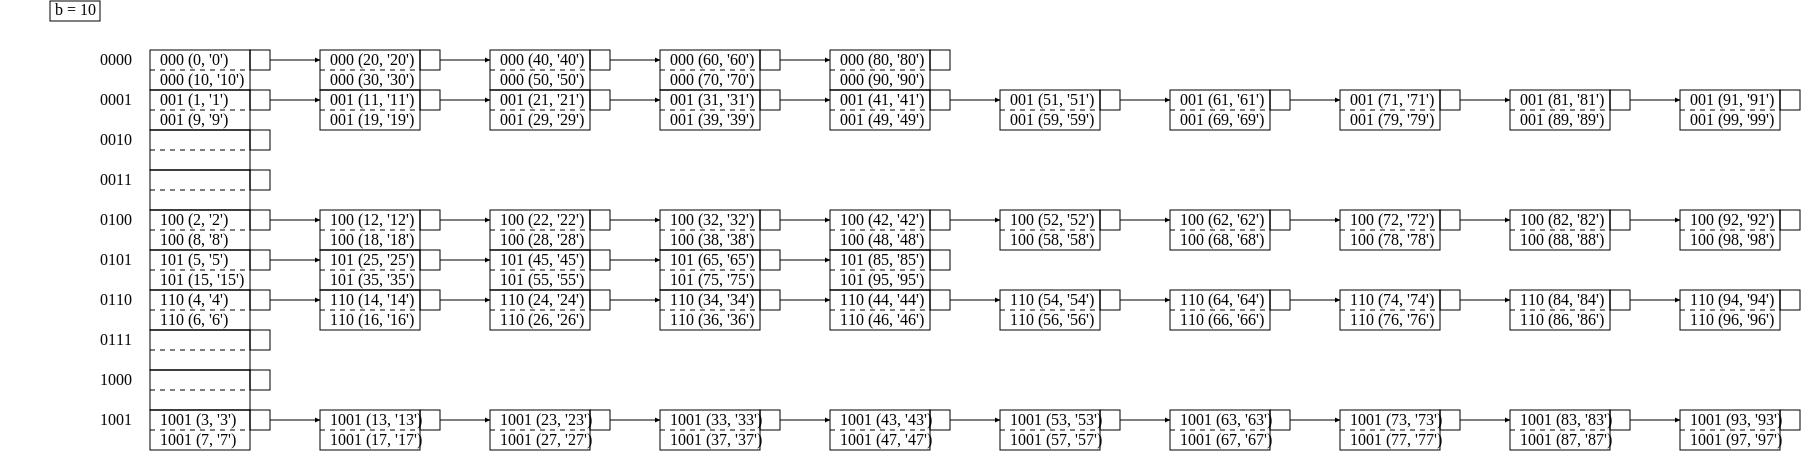

In [12]:
def h(x, b):
    return (x**2)%b

ht = ChainedHashTable(b = 10, k = 3)
ht.h = lambda x: h(x, ht.b)
for x in range(100):
    ht.insert((x, str(x)))
ht.show()

## Question 8 [25 or 0 pts]:

Implement the insert operation for extensible hash tables in the code above. Be sure to maintain the variable $i$ and the nub values of the buckets. You can assume that the bucket array has at least two buckets, and that $i \ge 1$. 

You can test your implementation by initializing an empty hash table (ex: `h = ExtensibleHashTable(k = 4)`), then inserting multiple strings or tuples, and then calling `h.show()` to see if the contents of the hash table matches your expectations. 

**Note** - These code fragments may be useful: 
 * `self.h(item[self.key_attr], i = self.i)`
 * `get_jth_bit_from_the_left(x, j + 1, self.k)`
 * `new_bucket = Bucket()`
 * `bucket.remove(item)`, `bucket.append(item)`

For reference, these are the steps for the insert operation:
 1. Compute the hash value of the key of a record, and take the first $i$ bits of this bit sequence.
 2. Find the bucket $B$ in the bucket array that is indexed by these $i$ bits.
 3. Add the new record to the bucket. 
 4. If the bucket had enough space for the new record, then we are finished. Otherwise if the bucket exceeded max capacity...
 5. Examine $j$ = the nub value of the bucket. If $j$ < $i$, then
     1. Split the bucket $B$ into two buckets. 
     2. Distribute records in $B$ to the two buckets, based on the value of the $(j+1)$th bit of their hash value - records with 0 in that bit stay in $B$ and records with 1 are moved to the new bucket. 
     3. Put $j + 1$ in each bucket's nub. 
     4. For the $x$th entry in the bucket array, if the entry used to point to $B$ and the $(j+1)$th bit of $x$ is 1, then the entry should point to the new bucket. 
     5. It may be the case that one of the buckets received all of the records of $B$. If this occurs, we must repeat the process 5A-5E on the overfull bucket. 
 6. Otherwise if $j$ = $i$, then
     1. First increment $i$ by 1. 
     2. Double the length of the bucket array, so that it has $2^{(i+1)}$ entries. 
     3. In the new bucket array, the entries indexed by the bit sequences $w0$ and $w1$ each point to the same bucket that the $w$ entry used to point to. 
     4. Now that $j$ < $i$, proceed to split the bucket using the steps in step 5. 
 
 You may receive partial credit based on the number of test cases your function passes, so it is recommended that you implement as many steps as possible. 

## Question 9 [0 or 25 pts]:

Implement the insert operation for linear hash tables in the code above. Be sure to maintain the variables $i$, $n$, and $r$. You can assume that the bucket array has at least two buckets, and that $i \ge 1$. 

You can test your implementation by initializing an empty hash table (ex: `h = LinearHashTable(f = 1.7, k = 4)`), then inserting multiple strings or tuples, and then calling `h.show()` to see if the contents of the hash table matches your expectations. 

**Note** - These code fragments may be useful: 
 * `self.h(item[self.key_attr], i = self.i)`
 * `m - 2 ** (self.i - 1)`
 * `self.r / self.n > self.f`
 * `new_bucket = Bucket()`
 * `clear_ith_bit_from_the_right(x, self.i)`, `get_ith_bit_from_the_right(x, self.i)`
 * `get_all_from_bucket(bucket)`, `insert_into_bucket(bucket, item, self.bucket_size)`, `delete_from_bucket(bucket, item, self.bucket_size)`
 
For reference, these are the steps for the insert operation:
 1. Compute the hash value of the key of a record, and take the last $i$ bits of this bit sequence as the variable $m$. 
 2. If $m < n$, then add the record to the bucket $m$, and if $m \ge n$, then add the record to the bucket $m - 2^{(i-1)}$. Use overflow buckets if necessary. 
 3. After inserting the record, compare the ratio $r / n$ with the threshold $f$. If the threshold is exceeded, we must add the next bucket to the table:
     1. Create a new bucket object, and append it to the bucket array. 
     2. If $n$ exceeds $2^i$, then $i$ is incremented by 1. 
     3. Assuming that the binary representation of the number of the new bucket is $1 a_2 \dots a_i$, we split the bucket with number $0 a_2 \dots a_i$, so that records whose $i$th bit from the right is 1 are moved to the new bucket. 
     

You may receive partial credit based on the number of test cases your function passes, so it is recommended that you implement as many steps as possible. 

# Part 4 - Quad Tree

The code below defines the classes: `Point`, `Rect`, and `QuadTree`. The `Point` class contains two numbers `x` and `y`, and it is immutable - once a `Point` object has been defined, its `x` and `y` values cannot be changed. The `Rect` class is defined in terms of two points - the bottom-left corner of the rectangle, and the top-right corner. 

The `QuadTree` class contains the methods:
 * `size()` - returns the number of points stored by the `QuadTree`
 * `depth()` - returns the maximum depth of any path through the `QuadTree`
 * `contains(pt)` - returns boolean for whether the `QuadTree` stores the given `Point`
 * `insert(pt)` - insert a new `Point` into the `QuadTree`, subdividing a leaf node if necessary. 
 * `delete(pt)` - remove a `Point` from the `QuadTree`, merging leaf nodes if possible. 
 * `find_points_in_region(region)` - return a list of all `Point`s within a region defined by a `Rect` object. 

In [13]:
class Counter:
    def __init__(self):
        self.__count = 0
        
    @property
    def count(self):
        return self.__count
    
    def inc(self):
        self.__count += 1
        
    def reset(self):
        self.__count = 0

class Point:
    def __init__(self, x, y):
        self.__x = x
        self.__y = y
        
    @property
    def x(self):
        global counter
        counter.inc()
        return self.__x
    
    @property
    def y(self):
        global counter
        counter.inc()
        return self.__y

    def __str__(self):
        return "({},{})".format(self.x, self.y)
        
    def __repr__(self):
        return "Point({}, {})".format(self.x, self.y)

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __iter__(self):
        return iter((self.x, self.y))
    
    def __len__(self):
        return len([v for v in self])
    
class Rect:
    def __init__(self, bottomleft_pt, topright_pt):
        self._p1 = bottomleft_pt
        self._p2 = topright_pt
        self._center = Point( (self._p1.x + self._p2.x) / 2,
                              (self._p1.y + self._p2.y) / 2)

    @property
    def p1(self):
        return self._p1

    @property
    def p2(self):
        return self._p2

    @property
    def center(self):
        return self._center
    
    @property
    def width(self):
        return self._p2.x - self._p1.x
    
    @property
    def height(self):
        return self._p2.y - self._p1.y

    def contains(self, pt):
        # NOTE the asymmetry in excluding upperbound
        return (self._p1.x <= pt.x < self._p2.x and
                self._p1.y <= pt.y <= self._p2.y)

    def intersects(self, other):
        return not (self.p2.x < other.p1.x or self.p1.x > other.p2.x or
                    self.p1.y > other.p2.y or self.p2.y < other.p1.y)

    def __repr__(self):
        return "Rect({}, {})".format(self._p1, self._p2)


class QuadTree:
    """QuadTree. See https://en.wikipedia.org/wiki/Quadtree
    
    Note: 
    1. Currently we allow same point to be inserted multiple times.
    2. We set a max depth (default = 8). 
    This is because if points are not unique, user can insert same points > node_capacity times
    which will cause infinite recursion since it is not possible to split the region to separate those points.    
    3. Rect.contains() does not include points on the boundary of x's upper limit but includes those with
    y's upper limit. This is to make the diagram in the following example match the result in the textbook.
    """

    # 4 regions/quadrants. From bottom-left to top-left.
    regions = ["SW", "SE", "NE", "NW"]
    SW = regions.index("SW")
    SE = regions.index("SE")
    NW = regions.index("NW")
    NE = regions.index("NE")
                    
    # Constant number of quadrants.
    K = 4

    def __init__(self, region, node_capacity=2, max_depth=8):
        self.node_capacity = node_capacity
        self._region = region
        self._children = [None] * self.K
        self._pts = []
        self.n = 2  # Working only with 2 attributes
        self._max_depth = max_depth

    @property
    def points(self):
        return self._pts
    
    @property
    def children(self):
        return self._children

    @property
    def region(self):
        return self._region
    
    def size(self):
        if self.is_leaf():
            return len(self._pts)
        else:
            return sum(c.size() for c in self._children)    
        
    def empty(self):
        # Should probably do some bookkeeping to track this value
        # instead of calling size()
        return self.size() == 0
        
    def depth(self):
        if self.is_leaf():
            return 0
        return 1 + max(c.depth() for c in self._children if c is not None)
    
    def is_leaf(self):
        return all(c is None for c in self._children)    
    
    def contains(self, pt):
        if not self._region.contains(pt):
            return False        

        if self.is_leaf():
            return any(p == pt for p in self._pts)

        return any(c.contains(pt) for c in self._children if c is not None)

    def insert(self, p):
        return self._insert(p, 0)        
        
    def _insert(self, p, depth):
        
        # Ignore objects that do not belong in this quad tree
        if not self._region.contains(p):
            return False # object cannot be added

        # If there is space in this quad tree, add the object here
        if self.is_leaf() and len(self._pts) < self.node_capacity:
            if depth < self._max_depth:
                self._pts.append(p)
                return True
            else:
                raise RuntimeError("Exceeded tree's max depth: {}".format(self._max_depth))
                assert False

        # Otherwise, subdivide and then add the point to whichever node will accept it
        if self.is_leaf():
            self._subdivide()

        if self._children[self.NW]._insert(p, depth + 1): return True
        if self._children[self.NE]._insert(p, depth + 1): return True
        if self._children[self.SW]._insert(p, depth + 1): return True
        if self._children[self.SE]._insert(p, depth + 1): return True        

        # Otherwise, the point cannot be inserted for some unknown reason (this should never happen)
        assert False, "Should not reach this point."
        return False
        
    def remove(self, pt):
        """Remove point from tree. Undo splits when possible."""
        if not self._region.contains(pt):
            return False
        if self.is_leaf():
            try:
                self._pts.remove(pt)
                return True
            except ValueError:
                return False                    
        else:
            for child in self._children:
                if child.remove(pt):
                    # Undivide if all child are empty
                    if all(c.empty() for c in self._children):
                        self._children = [None] * self.K
                    # Undivide if parent can hold all points
                    if self.size() <= self.node_capacity:
                        self._pts = self.all_points_in_tree()
                        self._children = [None] * self.K
                    return True
            return False

    def all_points_in_tree(self):
        result = []
        if self.is_leaf():
            return [Point(p.x, p.y) for p in self._pts]
        
        for qt in self._children:
            if qt is not None:
                result.extend(qt.all_points_in_tree())    
                
        return result
        
    def find_points_in_region(self, region):
        result = []

        # Automatically abort if the range does not intersect this quad
        if not self._region.intersects(region):
            return result # Empty list
        
        # Terminate here, if there are no children
        if self.is_leaf():
            return [p for p in self._pts if region.contains(p)]

        # Otherwise, add the points from the children
        for qt in self._children:
            if qt is not None:
                result.extend(qt.find_points_in_region(region))

        return result

    def _subdivide(self):
        # Create 4 children
        center = self._region.center
        p1 = self._region.p1
        p2 = self._region.p2
        
        nw_region = Rect(Point(p1.x, center.y), Point(center.x, p2.y))
        self._children[self.NW] = QuadTree(nw_region, self.node_capacity)

        ne_region = Rect(center, p2)
        self._children[self.NE] = QuadTree(ne_region, self.node_capacity)

        sw_region = Rect(p1, center)
        self._children[self.SW] = QuadTree(sw_region, self.node_capacity)

        se_region = Rect(Point(center.x, p1.y), Point(p2.x, center.y))
        self._children[self.SE] = QuadTree(se_region, self.node_capacity)

        # Distribute points
        for p in self._pts:
            for qt in self._children:
                if qt.insert(p):
                    break

        self._pts = []
        
    def show(self):
        display(SVG(data=quad_tree_to_svg(self, max_num_digits=3)))
        
    def plot(self, rect = None):
        try:
            import matplotlib.pyplot as plt
        except BaseException:
            print("Matplotlib is not installed")
            return
    
        ax = plot_tree_as_spatial_map(self, max_line_width=2, padx=1)
        if rect:
            ax = plot_points_in_region(ax, self, rect)
        plt.show()

## Question 10 [10 pts]:

Quadtrees are a type of data structure that can be used for indexing multidimensional data. Quadtrees have numerous applications outside of the DBMS domain. In this question, we will examine how Quadtrees can be used to optimize collision detection. Suppose that we have a set of points in a $100 \times 100$ region. We say that two points have **collided** if the Euclidean distance between the two points is less than some radius, $r = 3$. In addition, there is a **cost** that is incurred every time the program reads the $x$ or $y$ value of a point. We would like a function that finds all pairs of points that have collided, with the smallest runtime cost possible. 

In the code below, we have provided an $O(n^2)$ function for collision detection. Modify the function `quad_tree_collision_detection` so that it performs collision detection more efficiently, using the Quadtree class defined above. When you are finished, run the function `test_collision_detection` to test the accuracy and efficiency of your function. 

**Note** - the following methods may be of use: `distance()`, `tree.insert(),`, `tree.find_points_in_region()`, `tree.show()`, `tree.plot()`
 * The visualization functions `tree.show()` and `tree.plot()` will increase the cost of your function, so please be sure to remove such function calls before submitting your MP. 


In [14]:
counter = Counter()

# generate data
number_of_points = 100
radius = r = 3
points = []
x = 1
y = 1
for _ in range(number_of_points):
    x = (x * 1234.5 + 678.9) % 100
    y = (y * 9876.5 + 432.1) % 100
    points.append(Point(round(x, 1), round(y, 1)))
    
# find euclidean distance between two points
def distance(pt1, pt2):
    dx = pt1.x - pt2.x
    dy = pt1.y - pt2.y
    return sqrt(dx * dx + dy * dy)
    
def naive_collision_detection(points):
    for i, pt1 in enumerate(points):
        for pt2 in points[i + 1 :]:
            if distance(pt1, pt2) < radius:
#                 print(pt1)
#                 print(pt2)
                #print()
                yield pt1, pt2
# size() - returns the number of points stored by the QuadTree
# depth() - returns the maximum depth of any path through the QuadTree
# contains(pt) - returns boolean for whether the QuadTree stores the given Point
# insert(pt) - insert a new Point into the QuadTree, subdividing a leaf node if necessary.
# delete(pt) - remove a Point from the QuadTree, merging leaf nodes if possible.
# find_points_in_region(region) - return a list of all Points within a region defined by a Rect object.

def quad_tree_collision_detection(points):
    region = Rect(Point(0, 0), Point(100, 100))
    tree = QuadTree(region, node_capacity = 4)
    for pt in points:
        tree.insert(pt)
    
    for pt in points:
        
        new_region=Rect(Point(pt.x-3, pt.y-3), Point(pt.x+3, pt.y+3))
        for pt2 in tree.find_points_in_region(new_region):
            if pt==pt2:
                continue
            elif distance(pt,pt2)<radius:
                yield pt,pt2
        
    # write your answer to question 10 here
    # tree.show()
    
# def collide(tree,pt):
#     if tree.depth()==0 and distance(pt1, pt2) < radius:
#         return True
#     else:
        
        

def test_collision_detection():
    global counter
    counter.reset()
    collided1 = list(naive_collision_detection(points))
    #print(len(collided1))
    count1 = counter.count
    print("Total cost of naive collision detection:", count1)
    
    counter.reset()
    collided2 = list(quad_tree_collision_detection(points))
    #print(len(collided2))
    count2 = counter.count
    print("Total cost of quad tree collision detection:", count2)
    
    def _is_subset(s1, s2):
        for pt1, pt2 in s1:
            if not ((pt1, pt2) in s2 or (pt2, pt1) in s2):
                return False
        return True
    
    def _collision_sets_equal(s1, s2):
        return _is_subset(s1, s2) and _is_subset(s2, s1)
    
    assert _collision_sets_equal(collided1, collided2), \
           "Points detected by naive collision detection method " + \
           "do not match points detected by quad tree detection method"
    assert count1 > count2, \
           "Quad tree detection method should be more efficient than naive method"
        
test_collision_detection()
#quad_tree_collision_detection(points)


Total cost of naive collision detection: 19800
Total cost of quad tree collision detection: 15327


In [15]:
def _testQ1(n, s, k, b):
    return int(compute_size_of_dense_unclustered_index(n, s, k, b))

def testQ1():
    # n = 10, s = 8, k = 4, b = 20
    assert _testQ1(10, 8, 4, 20) == 2, "Not correct."
    
    # n = 100, s = 8, k = 4, b = 50
    assert _testQ1(100, 8, 4, 50) == 8, "Not correct."

    # n = 100, s = 8, k = 4, b = 49
    assert _testQ1(100, 8, 4, 49) == 9, "Not correct."

    # n = 100, s = 8, k = 6, b = 49
    assert _testQ1(100, 8, 6, 49) == 13, "Not correct."
    
    # n = 10, s = 12, k = 4, b = 20
    assert _testQ1(10, 12, 4, 20) == 2, "Not correct."
    
    print("Q1 PASS.")
def _testQ2(n, s, k, b):
    #print(int(compute_size_of_sparse_clustered_index(n, s, k, b)))
    return int(compute_size_of_sparse_clustered_index(n, s, k, b))
def testQ2():
    # n = 10, s = 8, k = 4, b = 20  (n*s)/b/k   size of records/blocksize  pointersize      
    assert _testQ2(10, 8, 4, 20) == 1, "Not correct."
    
    # n = 100, s = 8, k = 4, b = 50     (50/8=6,7) (100/4=25) s/k * n/b
    assert _testQ2(100, 8, 4, 50) == 2, "Not correct."
    
    # n = 100, s = 8, k = 4, b = 49
    assert _testQ2(100, 8, 4, 49) == 2, "Not correct."

    # n = 100, s = 8, k = 6, b = 49
    assert _testQ2(100, 8, 6, 49) == 3, "Not correct."
    
    # n = 10, s = 12, k = 4, b = 20
    assert _testQ2(10, 12, 4, 20) == 2, "Not correct."
    
    print("Q2 PASS.")

def testQ3_1():
    btree = BTree([19],
              [BTree([7, 13],
                     [BTree([3, 5], ["3", "5"]),
                      BTree([7, 11], ["7", "11"]),
                      BTree([13, 17], ["13", "17"])
                     ]),
               BTree([29],
                     [BTree([29], ["29"])])
              ],
              n = 2, d = 1)
    #btree.show()
    catched = False
    try:
        btree._check_block_usage_between_half_and_full()
    except AssertionError:
        catched = True
    if not catched:
        raise Exception("_check_block_usage_between_half_and_full() failed to detect errors.")
    
def testQ3():
    testQ3_1()
    print("Q3 PASS.")

def testQ4_1():
    btree = BTree([19, 31],
              [BTree([7, 13],
                     [BTree([3, 5], ["3", "5"]),
                      BTree([7, 11], ["7", "11"]),
                      BTree([13, 17], ["13", "17"])
                     ]),
               BTree([23],
                     [BTree([19], ["19"]),
                      BTree([23], ["23"])
                     ]),
               BTree([37], ["37"])
              ],
              n = 2, d = 1)
    #btree.show()
    catched = False
    try:
        btree.check(is_root = True)
    except AssertionError:
        catched = True
    if not catched:
        raise Exception("_check_is_balanced() failed to detect errors.")

def testQ4():
    testQ4_1()
    print("Q4 PASS.")
def testQ5_1():
    btree = BTree([19],
              [BTree([7, 13],
                     [BTree([3, 5], ["3", "5"]),
                      BTree([7, 11], ["7", "11"]),
                      BTree([13, 17], ["13", "17"])
                     ]),
               BTree([29, 31],
                     [BTree([19], ["19"]),
                      BTree([29], ["29"]),
                      BTree([31, 37], ["31", "37"])
                     ])
              ],
              n = 2, d = 1)
    #btree.show()
    assert btree.lookup(20) == None, "Found unexpected key 20"
    assert btree.lookup(31) == '31', "Key 37 not found in B-Tree"
    assert btree.lookup(7) == '7', "7 should exist"
    assert btree.lookup(37) == '37', "Key 37 not found in B-Tree"
    assert btree.lookup(2) == None, "2 should be none"   

    
def testQ5():
    testQ5_1()
    print("Q5 PASS.")
testQ1()
testQ2()
testQ3()
testQ4()
testQ5()
def _testQ7(num = 10):    
    ht = ChainedHashTable(b = 10, k = 3)
    ht.h = lambda x: h(x, ht.b)
    all = list(range(num))
    import random
    random.shuffle(all)
    for x in all:
        ht.insert((x, str(x)))
    #ht.show()
    myans = {}
    for i in range(10):
        bucket = ht.table[i]
        ret = get_all_from_bucket(bucket)
        ret.sort()
        #print(ret)
        keys = [x[0] for x in ret]
        if keys == []: continue
        myans[i] = keys
    return myans


def testQ7():
    ans = {}
    ans[10] = {0:[0], 1:[1, 9], 4:[2, 8], 5:[5], 6:[4, 6], 9:[3,7]}
    assert _testQ7(10) == ans[10], "Error in random insert 0 - 9"
    print("Q7 PASS.")    

def get_all_items(table):
    ret = []
    for w in table:
        ret.append(get_all_from_bucket(w))
    return ret

def testQ8_1():
    ht = ExtensibleHashTable(k = 4, bucket_size = 2)
    ht.insert((1, str(1)))
    ht.insert((3, str(3)))
    ht.insert((5, str(5)))
    ht.insert((7, str(7)))
    ans = [[(1, '1'), (3, '3')], [(5, '5'), (7, '7')], [], []]
    cur = get_all_items(ht.table)
    assert(cur == ans), "Check failed after 4 inserts."
    ht.insert((2, str(2)))
    ht.insert((4, str(4)))
    ans = [[(1, '1')], [(3, '3'), (2, '2')], [(5, '5'), (4, '4')], [(7, '7')], [], [], [], []]
    cur = get_all_items(ht.table)
    assert(cur == ans), "Check failed after 6 inserts."

def testQ8():
    testQ8_1()
    print("Q8 PASS.")
    pass

def get_all_items(table):
    ret = []
    for w in table:
        ret.append(get_all_from_bucket(w))
    return ret

def testQ9_1():
    ht = LinearHashTable(k = 4)
    ht.insert((1, str(1)))
    ans = [[], [(1, '1')]]
    cur = get_all_items(ht.table)
    assert(cur == ans), "Check failed after 1 insert."
    ht.insert((3, str(3)))
    ans = [[], [(1, '1'), (3, '3')]]
    cur = get_all_items(ht.table)
    assert(cur == ans), "Check failed after 2 inserts."
    ht.insert((2, str(2)))
    ans = [[(2, '2')], [(1, '1'), (3, '3')]]
    cur = get_all_items(ht.table)
    assert(cur == ans), "Check failed after 3 inserts."

def testQ9_2():
    ht = LinearHashTable(k = 4)
    ht.insert((1, str(1)))
    ht.insert((1, str(1)))
    ht.insert((1, str(1)))
    ans = [[], [(1, '1'), (1, '1'), (1, '1')]]
    cur = get_all_items(ht.table)
    assert(cur == ans), "Check failed after 3 inserts."
    ht.insert((1, str(1)))
    ans = [[], [(1, '1'), (1, '1'), (1, '1'), (1, '1')], []]
    cur = get_all_items(ht.table)
    assert(cur == ans), "Check failed after 4 inserts."

def testQ9():
    testQ9_1()
    testQ9_2()
    print("Q9 PASS.")
testQ7()

testQ9()


Q1 PASS.
Q2 PASS.
Q3 PASS.
Q4 PASS.
Q5 PASS.
Q7 PASS.
Q9 PASS.
